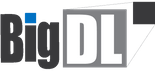

#  How to tune forecaster on one node


## introduction

In Chronos, Forecaster (bigdl.chronos.forecaster.Forecaster) is the forecasting abstraction. It hides the complex logic of model's creation, training, scaling to cluster, tuning, optimization and inferencing while expose some APIs for users (e.g. tune in this guide) to control.

In this guidance, **we demonstrate how to tune forecaster on one node**. Although Chronos supports tuning on a cluster, it's highly recommeneded to try one node first before allocating a cluster to make life easier.

In the tuning process, forecaster will try different parameter combinations. Chronos only support CPU (and transparent acceleration on Intel CPU) for tuning and training. Since time series data is not large, CPU training is enough for most cases.

We will take `AutoformerForecaster` and nyc_taxi dataset as an example in this guide.

## Setup

Before we begin, we need to install chronos if it isn’t already available, we choose to use pytorch as deep learning backend.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch, automl]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit()

## Step1 : Data preparation

First, we load the nyc taxi dataset.

Currently, Forecaster fit support three types of data representations: **TSDataset, Numpy Ndarray and pytorch dataloader / tf dataset**. 

However, tune func only support **Numpy Ndarray input**.

In [1]:
from sklearn.preprocessing import StandardScaler
from bigdl.chronos.data.repo_dataset import get_public_dataset

def get_tsdata():
    name = 'nyc_taxi'
    tsdata_train, tsdata_valid, tsdata_test = get_public_dataset(name)
    stand_scaler = StandardScaler()
    for tsdata in [tsdata_train, tsdata_valid, tsdata_test]:
        tsdata.impute(mode="linear")\
              .scale(stand_scaler, fit=(tsdata is tsdata_train))
    return tsdata_train, tsdata_valid, tsdata_test

tsdata_train, tsdata_valid, tsdata_test = get_tsdata()

train_data = tsdata_train.roll(lookback=20, horizon=1, time_enc=True, label_len=10).to_numpy()
val_data = tsdata_valid.roll(lookback=20, horizon=1, time_enc=True, label_len=10).to_numpy()
test_data = tsdata_test.roll(lookback=20, horizon=1, time_enc=True, label_len=10).to_numpy()

train/val/test_data is compose of (x, y, x_enc, y_enc) as we set `time_enc=True` which is only necessary for Autoformer.

x's shape is (num_samples, lookback, feature_dim) where lookback and feature_dim should be the same as past_seq_len and input_feature_num.

y's shape is (num_samples, horizon+label_len, target_dim), where horizon+label_len and target_dim should be the same as future_seq_len+label_len and output_feature_num.

x_enc's shape is (num_samples, lookback, time_dim) where lookback should be the same as past_seq_len and time_dim is related to freq.

y_enc's shape is (num_samples, horizon+label_len, time_dim), where horizon+label_len should be the same as future_seq_len+label_len and time_dim is related to freq.

## step2 : Tuning

### define forecaster with space
The first step of tuning a forecaster is to define forecaster with space parameters.

There are several common space choice:



In [ ]:
import bigdl.nano.automl.hpo.space as space
from bigdl.chronos.forecaster.autoformer_forecaster import AutoformerForecaster

autoformer = AutoformerForecaster(input_feature_num=1,
                                  output_feature_num=1,
                                  past_seq_len=20,
                                  future_seq_len=1,
                                  label_len=10,
                                  seed=1024,
                                  freq='t',
                                  loss="mse",
                                  metrics=['mae', 'mse', 'mape'],
                                  lr = space.Categorical(0.0001, 0.001, 0.01, 0.1),
                                  d_model=space.Categorical(32, 64, 128, 256),
                                  d_ff=space.Categorical(32, 64, 128, 256),
                                  e_layers=space.Categorical(1,2),
                                  n_head=space.Categorical(1,8))

In [ ]:
autoformer.tune(train_data, validation_data=val_data,
                n_trials=3, target_metric='mse', direction="minimize",
                epochs=4, batch_size=32)

Then, you can see the whole trial history by calling search_summary().

In [ ]:
autoformer.search_summary()

After tuning, the model parameters of autoformer is initialized according to the best trial params. You need to fit the model again.

### step 3 : fit and evaluate of model

In [ ]:
autoformer.fit(train_data, epochs=4, batch_size=32)
# evaluate on val set
evaluate = autoformer.evaluate(val_data)
print(evaluate)

## step4: save and load
After tuning and training, you can save your model by one line of code.

In [5]:
autoformer.save("best.ckpt")

Then, when you need to load, just call .load() func. Or if there is a new session, just define a new forecaster and load.

In [ ]:
autoformer.load("best.ckpt")
# evaluate on val set
evaluate = autoformer.evaluate(val_data)
print(evaluate)

In [ ]:
newformer = AutoformerForecaster(input_feature_num=1,
                                 output_feature_num=1,
                                 past_seq_len=20,
                                 future_seq_len=1,
                                 label_len=10,
                                 seed=1024,
                                 freq='t',
                                 loss="mse",
                                 metrics=['mae', 'mse', 'mape'])
newformer.load("best.ckpt")
# evaluate on val set
evaluate = newformer.evaluate(val_data)
print(evaluate)